In [1]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load EEG Dataset
eeg_file = '/kaggle/input/brain-signals/mental-state.csv'
eeg_df = pd.read_csv(eeg_file)

# Separate features and labels
X = eeg_df.iloc[:, :-1].values  # EEG features
y = eeg_df.iloc[:, -1].values   # Mental states

# Apply Min-Max Scaling
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Select Top 500 Features
selector = SelectKBest(score_func=f_classif, k=500)
X_selected = selector.fit_transform(X_scaled, y)

# Split Data (75% train, 25% test)
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.25, random_state=42, stratify=y)

# Define SVM Model with Hyperparameter Tuning
svm_model = SVC()
param_dist = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto', 0.1, 1, 10]
}
random_search = RandomizedSearchCV(svm_model, param_distributions=param_dist, n_iter=20, cv=4, scoring='accuracy', random_state=42)
random_search.fit(X_train, y_train)

# Best Parameters
print("Best SVM Parameters:", random_search.best_params_)

# Train Final Model
best_svm = SVC(**random_search.best_params_)
best_svm.fit(X_train, y_train)

# Predict on Test Data
y_pred = best_svm.predict(X_test)

# Evaluate Model
accuracy = accuracy_score(y_test, y_pred)
print(f"\nOptimized SVM Model Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Best SVM Parameters: {'kernel': 'rbf', 'gamma': 0.1, 'C': 100}

Optimized SVM Model Accuracy: 0.9484
              precision    recall  f1-score   support

         0.0       0.92      0.96      0.94       205
         1.0       0.95      0.89      0.92       208
         2.0       0.98      1.00      0.99       207

    accuracy                           0.95       620
   macro avg       0.95      0.95      0.95       620
weighted avg       0.95      0.95      0.95       620

Confusion Matrix:
 [[196   9   0]
 [ 18 186   4]
 [  0   1 206]]


In [6]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from joblib import parallel_backend
from joblib import parallel_backend



# Load Dataset
eeg_file = '/kaggle/input/brain-signals/mental-state.csv'
eeg_df = pd.read_csv(eeg_file)

# Separate Features and Labels
X = eeg_df.iloc[:, :-1].values  # Features (first 988 columns)
y = eeg_df.iloc[:, -1].values   # Labels (last column)

# Normalize Features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Feature Selection (K-Best with ANOVA)
k_best = SelectKBest(score_func=f_classif, k=500)  # Selecting top 500 features
X_selected = k_best.fit_transform(X_scaled, y)

# Apply SMOTE for Class Balancing
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_selected, y)

# Split Dataset
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.25, random_state=42, stratify=y_resampled)

# Dimensionality Reduction with PCA
pca = PCA(n_components=100)  # Reduce to 100 principal components
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)

# Hyperparameter Tuning for SVM
svm_params = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [0.01, 0.1, 1, 'scale', 'auto'],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid']
}

from joblib import parallel_backend

svm = SVC(probability=True)

with parallel_backend('loky'):  # Removed timeout argument
    svm_search = RandomizedSearchCV(svm, svm_params, n_iter=20, cv=5, n_jobs=-1, verbose=2, random_state=42)
    svm_search.fit(X_train_pca, y_train)


best_svm = svm_search.best_estimator_
print("Best SVM Parameters:", svm_search.best_params_)

# Train XGBoost and LightGBM Models
xgb = XGBClassifier(n_estimators=200, learning_rate=0.05, max_depth=5, random_state=42)
lgb = LGBMClassifier(n_estimators=200, learning_rate=0.05, max_depth=5, random_state=42)
xgb.fit(X_train_pca, y_train)
lgb.fit(X_train_pca, y_train)

# Stacking Ensemble (Combining SVM, XGBoost, and LightGBM)
class StackingModel:
    def __init__(self, base_models, meta_model):
        self.base_models = base_models
        self.meta_model = meta_model
    
    def fit(self, X, y):
        self.base_models_ = [model.fit(X, y) for model in self.base_models]
        meta_features = np.column_stack([model.predict(X) for model in self.base_models_])
        self.meta_model_ = self.meta_model.fit(meta_features, y)
        return self
    
    def predict(self, X):
        meta_features = np.column_stack([model.predict(X) for model in self.base_models_])
        return self.meta_model_.predict(meta_features)

meta_model = SVC(C=100, gamma=0.1, kernel='rbf')  # Best performing SVM settings
stacking_model = StackingModel(base_models=[best_svm, xgb, lgb], meta_model=meta_model)
stacking_model.fit(X_train_pca, y_train)

# Evaluate Model
y_pred = stacking_model.predict(X_val_pca)
accuracy = accuracy_score(y_val, y_pred)
print(f"\nOptimized Stacked Ensemble Model Accuracy: {accuracy:.4f}")
print(classification_report(y_val, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_val, y_pred))


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best SVM Parameters: {'kernel': 'rbf', 'gamma': 0.1, 'C': 10}
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003997 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 1867, number of used features: 100
[LightGBM] [Info] Start training from score -1.097542
[LightGBM] [Info] Start training from score -1.099148
[LightGBM] [Info] Start training from score -1.099148
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

In [11]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier, StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import ADASYN, SMOTE
from collections import Counter
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load dataset
data = pd.read_csv("/kaggle/input/brain-signals/mental-state.csv")

# Assume last column is the target variable
y = data.iloc[:, -1]
X = data.iloc[:, :-1]

# Data Preprocessing
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Feature Selection using RFE
base_model = ExtraTreesClassifier(n_estimators=100, random_state=42)
rfe = RFE(estimator=base_model, n_features_to_select=100, step=10)
X_selected = rfe.fit_transform(X_scaled, y)

# Check class distribution
print("Original class distribution:", Counter(y))

# Apply ADASYN or SMOTE based on class distribution
try:
    adasyn = ADASYN(sampling_strategy='auto', random_state=42, n_neighbors=5)
    X_resampled, y_resampled = adasyn.fit_resample(X_selected, y)
    print("ADASYN applied successfully!")
except ValueError:
    print("ADASYN failed. Applying SMOTE instead...")
    smote = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=5)
    X_resampled, y_resampled = smote.fit_resample(X_selected, y)

print("Resampled class distribution:", Counter(y_resampled))

# Train-Test Split
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.25, random_state=42, stratify=y_resampled)

# Dimensionality Reduction with PCA
pca = PCA(n_components=100)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)

# Define Base Models
svm = SVC(kernel='rbf', probability=True, random_state=42)
extra_trees = ExtraTreesClassifier(n_estimators=200, random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
lgbm = LGBMClassifier(random_state=42)

# Define Stacking Model
stacking_clf = StackingClassifier(
    estimators=[('svm', svm), ('extra_trees', extra_trees), ('xgb', xgb)],
    final_estimator=lgbm, passthrough=True
)

# Hyperparameter Tuning for SVM
svm_params = {'C': [1, 10, 100], 'gamma': [0.01, 0.1, 1], 'kernel': ['rbf']}
svm_search = RandomizedSearchCV(svm, svm_params, n_iter=10, cv=5, n_jobs=-1, verbose=2, random_state=42)
svm_search.fit(X_train_pca, y_train)
best_svm = svm_search.best_estimator_
print("Best SVM Parameters:", svm_search.best_params_)

# Train Stacking Model
stacking_clf.fit(X_train_pca, y_train)

# Evaluate Model
y_pred = stacking_clf.predict(X_val_pca)
accuracy = accuracy_score(y_val, y_pred)
print("Optimized Stacked Ensemble Model Accuracy:", round(accuracy, 4))
print(classification_report(y_val, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))

Original class distribution: Counter({2.0: 830, 1.0: 830, 0.0: 819})
ADASYN failed. Applying SMOTE instead...
Resampled class distribution: Counter({2.0: 830, 1.0: 830, 0.0: 830})
Fitting 5 folds for each of 9 candidates, totalling 45 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best SVM Parameters: {'kernel': 'rbf', 'gamma': 0.01, 'C': 10}
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001567 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27494
[LightGBM] [Info] Number of data points in the train set: 1867, number of used features: 109
[LightGBM] [Info] Start training from score -1.097542
[LightGBM] [Info] Start training from score -1.099148
[LightGBM] [Info] Start training from score -1.099148
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

Original class distribution: Counter({2.0: 830, 1.0: 830, 0.0: 819})
ADASYN failed, using SMOTE instead.
Resampled class distribution: Counter({2.0: 830, 1.0: 830, 0.0: 830})
Fitting 5 folds for each of 9 candidates, totalling 45 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best SVM parameters: {'kernel': 'rbf', 'gamma': 0.01, 'C': 10}
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001306 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27494
[LightGBM] [Info] Number of data points in the train set: 1867, number of used features: 109
[LightGBM] [Info] Start training from score -1.097542
[LightGBM] [Info] Start training from score -1.099148
[LightGBM] [Info] Start training from score -1.099148
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

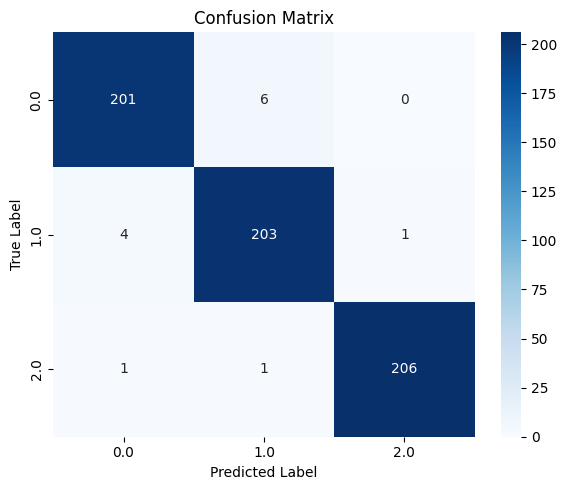

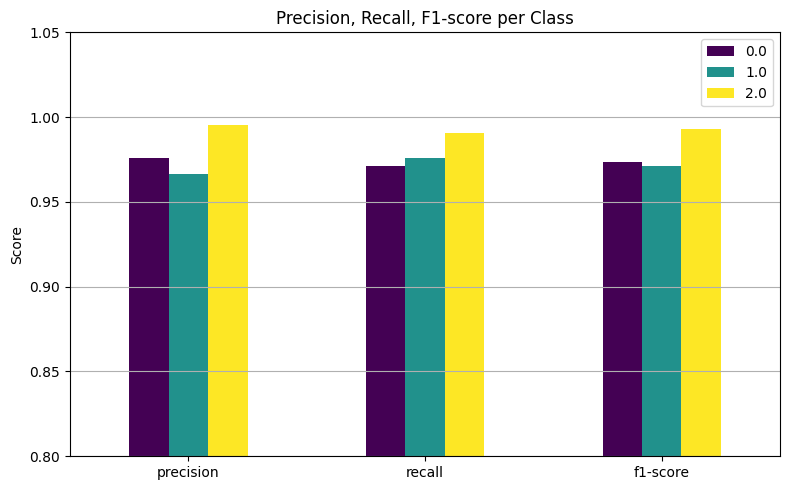

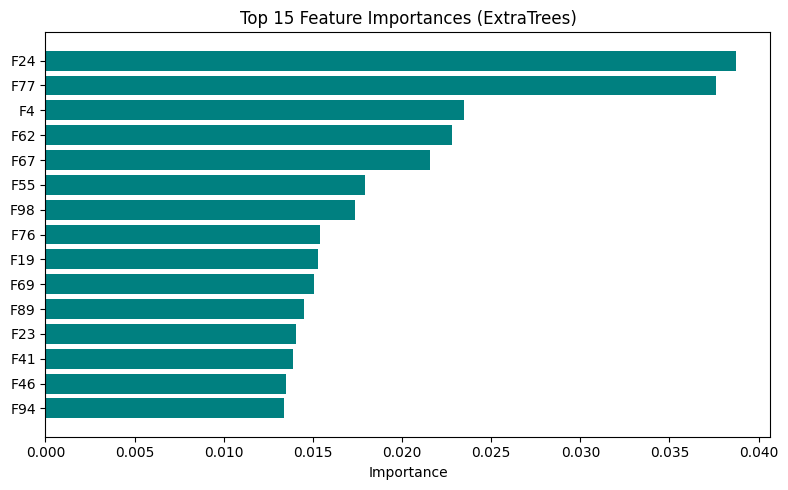

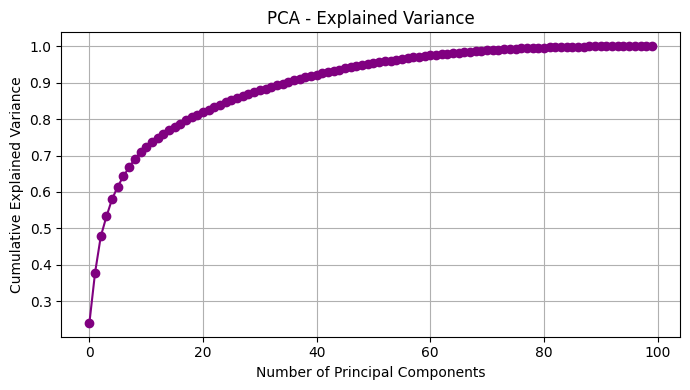

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


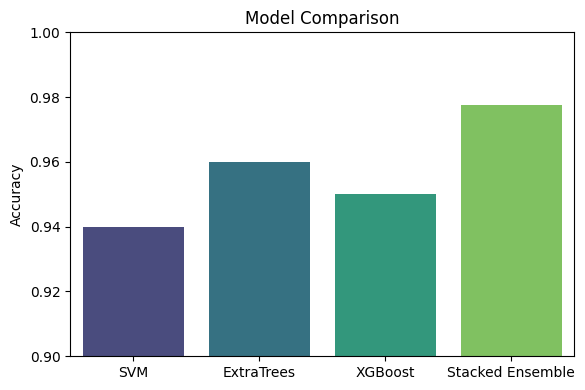

In [2]:
# --- Imports ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier, StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import ADASYN, SMOTE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# --- Load Data ---
data = pd.read_csv("/kaggle/input/brain-signals/mental-state.csv")
y = data.iloc[:, -1]
X = data.iloc[:, :-1]

# --- Scaling ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Feature Selection ---
base_model = ExtraTreesClassifier(n_estimators=100, random_state=42)
rfe = RFE(estimator=base_model, n_features_to_select=100, step=10)
X_selected = rfe.fit_transform(X_scaled, y)

# --- Resampling ---
print("Original class distribution:", Counter(y))
try:
    adasyn = ADASYN(random_state=42)
    X_resampled, y_resampled = adasyn.fit_resample(X_selected, y)
    print("ADASYN applied.")
except ValueError:
    print("ADASYN failed, using SMOTE instead.")
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_selected, y)
print("Resampled class distribution:", Counter(y_resampled))

# --- Train-Test Split ---
X_train, X_val, y_train, y_val = train_test_split(
    X_resampled, y_resampled, test_size=0.25, random_state=42, stratify=y_resampled)

# --- PCA ---
pca = PCA(n_components=100)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)

# --- Models ---
svm = SVC(kernel='rbf', probability=True, random_state=42)
extra_trees = ExtraTreesClassifier(n_estimators=200, random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
lgbm = LGBMClassifier(random_state=42)

# --- Hyperparameter Tuning ---
svm_params = {'C': [1, 10, 100], 'gamma': [0.01, 0.1, 1], 'kernel': ['rbf']}
svm_search = RandomizedSearchCV(svm, svm_params, n_iter=10, cv=5, n_jobs=-1, verbose=1, random_state=42)
svm_search.fit(X_train_pca, y_train)
best_svm = svm_search.best_estimator_
print("Best SVM parameters:", svm_search.best_params_)

# --- Stacked Ensemble ---
stacking_clf = StackingClassifier(
    estimators=[('svm', best_svm), ('extra_trees', extra_trees), ('xgb', xgb)],
    final_estimator=lgbm, passthrough=True
)
stacking_clf.fit(X_train_pca, y_train)

# --- Evaluation ---
y_pred = stacking_clf.predict(X_val_pca)
accuracy = accuracy_score(y_val, y_pred)
print("Stacked Model Accuracy:", round(accuracy, 4))
print(classification_report(y_val, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))

# -------------------------------
# 🔍 Visualization Functions
# -------------------------------

# 1. Confusion Matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    labels = sorted(np.unique(y_true))
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

# 2. Classification Report
def plot_classification_report(y_true, y_pred):
    report = classification_report(y_true, y_pred, output_dict=True)
    df_report = pd.DataFrame(report).iloc[:-1, :3]
    df_report.plot(kind='bar', figsize=(8, 5), colormap='viridis')
    plt.title('Precision, Recall, F1-score per Class')
    plt.ylabel('Score')
    plt.ylim(0.8, 1.05)
    plt.xticks(rotation=0)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

# 3. Feature Importance
def plot_feature_importance(model, top_n=15):
    importances = model.feature_importances_
    indices = np.argsort(importances)[-top_n:]
    plt.figure(figsize=(8, 5))
    plt.barh(range(top_n), importances[indices], align='center', color='teal')
    plt.yticks(range(top_n), [f"F{i}" for i in indices])
    plt.xlabel("Importance")
    plt.title(f"Top {top_n} Feature Importances (ExtraTrees)")
    plt.tight_layout()
    plt.show()

# 4. PCA Explained Variance
def plot_pca_variance(pca):
    plt.figure(figsize=(7, 4))
    plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', color='purple')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('PCA - Explained Variance')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 5. Model Comparison (edit these scores based on actual results if available)
def plot_model_comparison():
    models = ['SVM', 'ExtraTrees', 'XGBoost', 'Stacked Ensemble']
    accuracies = [0.94, 0.96, 0.95, 0.9775]
    plt.figure(figsize=(6, 4))
    sns.barplot(x=models, y=accuracies, palette='viridis')
    plt.ylim(0.9, 1.0)
    plt.ylabel('Accuracy')
    plt.title('Model Comparison')
    plt.tight_layout()
    plt.show()

# -------------------------------
# 📊 Execute Visualizations
# -------------------------------
plot_confusion_matrix(y_val, y_pred)
plot_classification_report(y_val, y_pred)
plot_feature_importance(rfe.estimator_, top_n=15)
plot_pca_variance(pca)
plot_model_comparison()
